# Current Population Survey (CPS)
This survey contains data on things like unemployment, and income. The goal of this will be to create a Machine Learning algorithm that
can predict the relative wealth of an individual. The data set will be split into 2 groups; people who make above $75,000 a year and the
people who are below that amount. The data available is only total family data, so married couples will be added together. The idea is that 
this sort of technique could be used to seperate customers into two groups for the purpose of group pricing models. A group pricing model is where different
groups of customers are charged a different price, of which a common example is senior discounts, or websites like amazon with a membership fee for discounts 
on shipping. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sympy as sym
sym.init_printing(use_latex=True)
import random



The needed packages have been imported for use in this notebook. 
<br> Now i will load in the data from the CPS, this data is from may 2025. This is the most recent data as of the time of writing.

In [2]:
file_1 = 'D:\data_analysis\may25pub.csv'

In [3]:
df = pd.read_csv(file_1)

In [4]:
df.head()

,hrhhid2,HUFINAL,OCCURNUM,HUINTTYP,HURESPLI,HUPRSCNT,HUTYPEA,HUTYPB,HUTYPC,HUBUS,...,ptot,ptwk,pthr,gtcbsa,gtco,gtcbsast,gtcbsasz,gtcsa,gtmetsta,gtindvpc
0,18011,201,1,2,1,0,-1,-1,-1,2,...,0,0,0,12220,81,4,2,194,1,0
1,18011,201,2,2,1,0,-1,-1,-1,2,...,0,0,0,12220,81,4,2,194,1,0
2,18011,201,3,2,1,0,-1,-1,-1,2,...,0,0,0,12220,81,4,2,194,1,0
3,18011,201,1,2,1,0,-1,-1,-1,1,...,0,0,0,12220,81,4,2,194,1,0
4,18011,201,2,2,1,0,-1,-1,-1,1,...,0,0,0,12220,81,4,2,194,1,0


The data is hard to read like this. I will change the collumn names and pick the most relevant data points. 

In [5]:
len(df)

In [ ]:
df['age'] = df['prtage']
del df['prtage']

df['FamilyIncome'] = df['hefaminc']
del df['hefaminc']

df['State'] = df['gestfips']
del df['gestfips']

df['Full_or_Part_time'] = df['prwkstat']
del df['prwkstat']

df['LaborForceStatus'] = df['pemlr']
del df['pemlr']
#
df['Business/Farm'] = df['HUBUS']
del df['HUBUS']
#
df['marital_status'] = df['pemaritl']
del df['pemaritl']
#
df['gender'] = df['pesex']
del df['pesex']
#
df['education'] = df['peeduca']
del df['peeduca']
#
df['OvertimeThisWeek'] = df['PUHROT1']
del df['PUHROT1']

C:\Users\adamp\AppData\Local\Temp\ipykernel_13684\2542860919.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['FamilyIncome'] = df['hefaminc']
C:\Users\adamp\AppData\Local\Temp\ipykernel_13684\2542860919.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Business/Farm'] = df['HUBUS']
C:\Users\adamp\AppData\Local\Temp\ipykernel_13684\2542860919.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

In [13]:
df_final = df[['Business/Farm','education','marital_status','gender','FamilyIncome','OvertimeThisWeek','State','age','Full_or_Part_time','LaborForceStatus']]

In [14]:
df_final.head()

,Business/Farm,education,marital_status,gender,FamilyIncome,OvertimeThisWeek,State,age,Full_or_Part_time,LaborForceStatus
0,2,39.0,4.0,1.0,13,-1.0,1,54.0,1.0,5.0
1,2,39.0,4.0,2.0,13,2.0,1,40.0,2.0,1.0
2,2,36.0,6.0,2.0,13,2.0,1,17.0,7.0,1.0
3,1,42.0,1.0,1.0,13,2.0,1,35.0,2.0,1.0
4,1,39.0,1.0,1.0,13,2.0,1,33.0,2.0,1.0


# <center> The data is almost ready.
Ok, this data set is much easier to read and use. The data points i have chosen are: do they own their own business or farm, 
The level of education, if they are married (since married will add income together), what gender, their income, if they worked overtime this week,
if they work full or part time, what state they live in, how old they are and whats their official labor force status. 
<br><br>
Now i must rename the data points to be easier to read and process, most of these renames should make sense. 
<br>
For the unemployed label, i put everyone into the catagories of full time, part time, or unemployed with not in the labor force possible. 

In [ ]:
gender_catagories = {1:'Male',2:'Female'}
marital_catagories = {1:'married-present',2:'married-absent',3:'widowed',4:'divorced',5:'seperated',6:'never_married'}
#income_catagories = {1:'<5,000',2:'5,000-7,499',3:'7,500-9,999',4:'10,000-12,499',5:'12,500-14,999',6:'15,000-19,999',7:'20,000-24,999',8:'25,000-29,999',9:'30,000-34,999',10:'35,000-39,999',11:'40,000-49,999',12:'50,000-59,999',13:'60,000-74,999',14:'75,000-99,999',15:'100,000-149,999',16:'150,000-up'}
#income_catagories = {1:'<50,000',2:'<50,000',3:'<50,000',4:'<50,000',5:'<50,000',6:'<50,000',7:'<50,000',8:'<50,000',9:'<50,000',10:'<50,000',11:'<50,000',12:'>=50,000',13:'>=50,000',14:'>=50,000',15:'>=50,000',16:'>=50,000'}

# the above is for splitting everyone into 2 groups: rich or poor, the first is the actual catagories, the second, is above or below 50,000 and the one used below is 75,000 divider.
income_catagories = {1:'<75,000',2:'<75,000',3:'<75,000',4:'<75,000',5:'<75,000',6:'<75,000',7:'<75,000',8:'<75,000',9:'<75,000',10:'<75,000',11:'<75,000',12:'<75,000',13:'<75,000',14:'>=75,000',15:'>=75,000',16:'>=75,000'}

farm_catagories = {1:'yes',2:'no'}
education_catagories = {31:'None',32:'4th_grade',33:'6th',34:'8th',35:'9th',36:'10th',37:'11th',38:'12th',39:'highschool',40:'some_college',41:'AA-occupational',42:'AA',43:'Bachelors',44:'Masters',45:'Preffessional',46:'PHD'}
overtime_catagories = {-1:'No',1:'Yes',2:'No'}
state_catagories = {1:'AL',2:'AK',4:'AK',5:'AR',6:'CA',8:'CO',9:'CT',10:'DE',11:'DC',12:'FL',13:'GA',15:'HI',16:'ID',17:'IL',18:'IN',19:'IA',20:'KS',21:'KY',22:'LA',23:'ME',24:'MD',25:'MA',26:'MI',27:'MN',28:'MS',29:'MO',30:'MT',31:'NE',32:'NV',33:'NH',34:'NJ',35:'NM',36:'NY',37:'NC',38:'ND',39:'OH',40:'OK',41:'OR',42:'PA',44:'RI',45:'SC',46:'SD',47:'TN',48:'TX',49:'UT',50:'VT',51:'VA',53:'WA',54:'WV',55:'WI',56:'WY'}
employment_catagories = {1:'not_in_labor_force',2:'full_time',3:'part_time',4:'part_time',5:'unemployed',6:'part_time',7:'part_time',8:'full_time',9:'full_time',10:'part_time',11:'unemployed',12:'unemployed'}
labor_force_catagories = {1:'employed',2:'employed',3:'unemployed',4:'unemployed',5:'retired',6:'disabled',7:'Other'}






In [16]:
df_final['gender'] = df_final['gender'].map(gender_catagories)
df_final['marital_status'] = df_final['marital_status'].map(marital_catagories)
df_final['FamilyIncome'] = df_final['FamilyIncome'].map(income_catagories)
df_final['Business/Farm'] = df_final['Business/Farm'].map(farm_catagories)
df_final['education'] = df_final['education'].map(education_catagories)
df_final['OvertimeThisWeek'] = df_final['OvertimeThisWeek'].map(overtime_catagories)
df_final['State'] = df_final['State'].map(state_catagories)
df_final['LaborForceStatus'] = df_final['LaborForceStatus'].map(labor_force_catagories)
df_final['Full_or_Part_time'] = df_final['Full_or_Part_time'].map(employment_catagories)

C:\Users\adamp\AppData\Local\Temp\ipykernel_13684\549138963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['gender'] = df_final['gender'].map(gender_catagories)
C:\Users\adamp\AppData\Local\Temp\ipykernel_13684\549138963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['marital_status'] = df_final['marital_status'].map(marital_catagories)
C:\Users\adamp\AppData\Local\Temp\ipykernel_13684\549138963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [18]:
df_final.sample(10)

,Business/Farm,education,marital_status,gender,FamilyIncome,OvertimeThisWeek,State,age,Full_or_Part_time,LaborForceStatus
60616,no,Masters,married-present,Female,">=75,000",No,NJ,73.0,not_in_labor_force,retired
80697,no,Masters,divorced,Female,"<75,000",No,OR,69.0,full_time,employed
18795,NaN,NaN,NaN,NaN,NaN,NaN,FL,NaN,NaN,NaN
58940,no,Masters,married-present,Male,">=75,000",No,FL,43.0,full_time,employed
110917,yes,Preffessional,married-present,Male,"<75,000",No,NM,50.0,full_time,employed
1993,no,highschool,married-present,Female,"<75,000",No,MD,67.0,not_in_labor_force,retired
43831,no,some_college,married-present,Female,">=75,000",No,NH,85.0,not_in_labor_force,retired
26329,no,8th,divorced,Female,"<75,000",No,AL,35.0,full_time,employed
54737,no,AA,married-present,Female,"<75,000",No,OR,56.0,part_time,employed
86375,yes,some_college,married-present,Male,">=75,000",No,NE,41.0,full_time,employed


The data set is now finished and ready for use in the Machine Learning part of this analysis. the last thing i must do is remove the missing rows.

In [19]:
df_final.isnull().sum()

Business/Farm        28678
education            44023
marital_status       44023
gender               28434
FamilyIncome         28434
OvertimeThisWeek     28594
State                    0
age                  28434
Full_or_Part_time    44349
LaborForceStatus     44349
dtype: int64

In [20]:
len(df_final)

In [21]:
df = df_final.dropna()

In [22]:
df.isnull().sum()

Business/Farm        0
education            0
marital_status       0
gender               0
FamilyIncome         0
OvertimeThisWeek     0
State                0
age                  0
Full_or_Part_time    0
LaborForceStatus     0
dtype: int64

In [23]:
len(df)

After removing the rows with missing values, i am left with 78,737 rows of data, this should be enough for a good result. 

Below is the organization of the data according to education levels. It is interesting to note that there are more people with some college or a college degree than only highschool education.

In [24]:
df['education'].value_counts()

education
highschool         21787
Bachelors          17058
some_college       11552
Masters             7801
AA                  4516
AA-occupational     3578
11th                2044
10th                2015
9th                 1737
PHD                 1649
8th                 1358
12th                1356
Preffessional       1097
6th                  671
4th_grade            332
None                 186
Name: count, dtype: int64

In [25]:
df['FamilyIncome'].value_counts()

FamilyIncome
>=75,000    42955
<75,000     35782
Name: count, dtype: int64

In [26]:
X = df.drop(columns=['FamilyIncome'])
y = df['FamilyIncome']

Here i am splitting the data set for training and testing

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X ,y , test_size=0.2, stratify=y)

Here is the setup for the random forest classifier ML method.

In [ ]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


param_grid = {
    'classifier__n_estimators': [50,100],
    'classifier__max_depth': [None,20, 40],
    'classifier__min_samples_split': [2,6]
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

In [30]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  24.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  24.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  24.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  24.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=  24.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  49.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  49.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Business/Farm',
                                                                          'education',
                                                                          'marital_status',
                                                                          'gender',
                                                                          'OvertimeThisWeek',
                                                                          'State',
                                                                          'Full_or_Part_time',
                                                                          'LaborForceStatus'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [None, 20, 40],
                         'classifier__min_samples_split': [2, 6],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

The random forest classifier is done, now to display the  best parameters. for this data choosing a larger number for the minimum sample split, and more classifiers helps with this dataset. 

In [31]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
test_score = grid_search.score(X_test, y_test)  
print("Test set score: {:.2f}".format(test_score))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 100}
Best cross-validation score: 0.71
Test set score: 0.71


a test score is 0.71 is good for this type of question and dataset

In [32]:
y_pred = grid_search.predict(X_test)

In [33]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

     <75,000       0.69      0.64      0.66      7157
    >=75,000       0.72      0.76      0.74      8591

    accuracy                           0.71     15748
   macro avg       0.70      0.70      0.70     15748
weighted avg       0.70      0.71      0.70     15748



Here you can see the full report above, with the confusion matrix below. 
<br>There is a higher precision and accuracy when trying to find a rich household rather than a less wealthy one. 
<br>This same analysis could be done with a different level of wealth determing if someone is rich, say $150,000. 

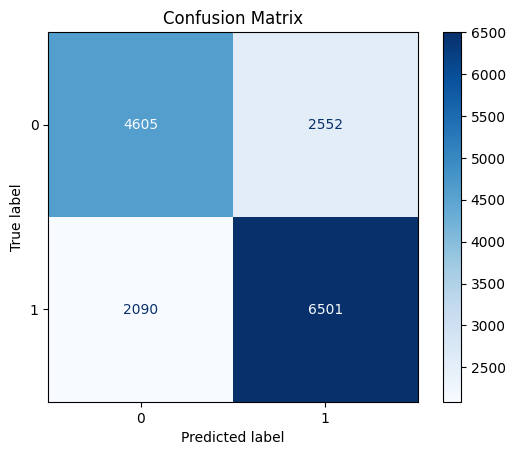

<Figure size 1200x1200 with 0 Axes>

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.figure(figsize=(12,12))
plt.show()

Now, using this model, lets create an economic example to demostrate.
<br>Let us suppose that there is a customer base. to do this i will create a distrubition of theoretical customers.
The data will be used from the predictions of the test set. That will create the budget for the pricing economic model.
The actual income data will be used to create the result economic model.

In [37]:
y_test = pd.DataFrame(y_test)

In [ ]:
class Customer():
    """This class holds the information for each customer. The customer will have a budget, and a utility curve for 2 consumer goods."""

    def __init__(self, budget,utility_fuction,business,education,marital_status,gender,OvertimeThisWeek,state,age,Full_or_Part_time ,LaborForceStatus,alpha ):
        
        # loading in the variables that make each customer unique.
        self.utility_function = utility_fuction
        self.budget = budget
        self.education = education
        self.business = business
        self.marital_status = marital_status
        self.gender = gender
        self.overtime = OvertimeThisWeek
        self.state = state
        self.age = age
        self.fullorpart = Full_or_Part_time
        self.labor_force = LaborForceStatus
        self.alpha_data = alpha
        
        self.x,self.y,self.p_x,self.p_y,self.u,self.alpha, self.L,self.income = sym.symbols('X,Y,p_x,p_y,U,alpha,L,I')

    def find_demand_and_solve(self):
        """This will find the Quantity of goods demanded at a given set of prices."""

        if self.utility_function == 'default':
            """This will be cobb-douglas"""
            self.utility = (self.x**self.alpha ) * (self.y ** (1 - self.alpha ))
            self.constraint = (self.income / 52) - (self.x * self.p_x) -( self.y * self.p_y)

            self.lagrangian = self.utility - self.L * self.constraint
            gradient = sym.Matrix([[self.lagrangian]]).jacobian([self.x,self.y,self.L])
            foc = [sym.Eq(i,0) for i in gradient]

            self.solution = (sym.solve(foc,(self.x,self.y,self.L))) 
            
    def display_solution(self):
        """this shows the equation for testing"""

        print('good x: ',self.solution[0][0],' : ', '      Good y:',self.solution[0][1])

    def return_solution(self,price_x,price_y,alpha_info,income):
        """this takes in the data and returns solution"""
        good_x_solution =  round(self.solution[0][0].subs([(self.alpha,alpha_info),(self.p_x,price_x),(self.income,income)]),0)
        good_y_solution =  round(self.solution[0][1].subs([(self.alpha,alpha_info),(self.p_y,price_y),(self.income,income)]),0)

        return (good_x_solution,good_y_solution)



In [39]:
n = 0
#m = 5
m = len(X_test) 
list_customers = []
price_of_first_good = 10
price_of_second_good = 15
a = y_test['FamilyIncome']
b = X_test['Business/Farm']
c =  X_test['education']
d = X_test['marital_status']
e = X_test['gender']
f = X_test['OvertimeThisWeek']
g = X_test['State']
h = X_test['age']
i = X_test['Full_or_Part_time']
j = X_test['LaborForceStatus']

while n < m:
    temp = random.randrange(10,90,1) # [0.1,0.9] domain for alpha
    temp /= 100
    if a.iloc[n] == '>=75,000':
        z = Customer(75000,'default',b.iloc[n],c.iloc[n],d.iloc[n],e.iloc[n],f.iloc[n],g.iloc[n],h.iloc[n],i.iloc[n],j.iloc[n],temp)
    if a.iloc[n] == '<75,000':
        z = Customer(45000,'default',b.iloc[n],c.iloc[n],d.iloc[n],e.iloc[n],f.iloc[n],g.iloc[n],h.iloc[n],i.iloc[n],j.iloc[n],temp)
    list_customers.append(z)
    n += 1


This will have created a list of customers from the data who have two possible incomes. For over 75000: $75,000 will be used as income.Then for below 75,000, $45,000 will be used since it is close to the average GDP per capita. Other numbers could be used. Good B will represent an index of goods, while Good A will represent the good sold by firm. This way the accuracy of the model will be shown by the difference in sales predicted by the model, compared to the actual data. The ML model will be used to predict the income of the customers so that the firm can predict how many sales they will get in the next week. This will be compared to the actual income, used in the same economic model of Utility maximization using a Cobb-Douglas utility function and a budget constraint. One budget constraint will use the actual income, the other will use the predicted income.   

In [ ]:
list_customers[0].find_demand_and_solve()

In [41]:
list_customers[0].display_solution()

good x:  I*alpha/(52*p_x)  :        Good y: I*(1 - alpha)/(52*p_y)


Now as the firm, we can set a price and find theoritcal sales. The variable alpha must also be set and is exogenous, and will be determined by a random number and must  be between [0.1,0.9]. Theoritcally alpha has possible values between [0,1].  

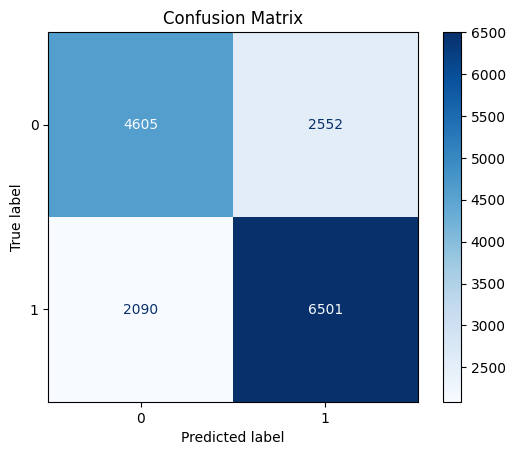

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
#plt.figure(figsize=(12,12))
plt.show()

We will use the predicted labels to make the economic decisions. for this there are 6509 + 2448 rich labels, and 4709 + 2082 middle class labels.

In [76]:
len(y_pred)

In [78]:
rich_people = 0 #6509+2448
poor_people = 0 # 4709+2082

n = 0
m = len(y_pred)

while n < m:
    if y_pred[n] == '<75,000':
        poor_people += 1
    if y_pred[n] == '>=75,000':
        rich_people += 1
    n += 1

In [79]:
print('there are ',rich_people, ' rich people\nThere are ',poor_people,' poor people')

there are  9053  rich people
There are  6695  poor people


In [80]:
chosen_price_good_x = 10
price_index_other_goods = 5


n = 0
#m = 10
m = len(list_customers)
total_sales_predicted = 0
while n < m:
    if y_pred[n] == '<75,000':
        total_sales_predicted += list_customers[0].return_solution(chosen_price_good_x,price_index_other_goods,list_customers[n].alpha_data,45000)[0]
    else:
        total_sales_predicted += list_customers[0].return_solution(chosen_price_good_x,price_index_other_goods,list_customers[n].alpha_data,75000)[0]
    n += 1

In [81]:
print(total_sales_predicted)

933353.000000000


In [82]:
n = 0
#m = 10
m = len(list_customers)
total_sales_actual = 0
while n < m:
    total_sales_actual += list_customers[0].return_solution(chosen_price_good_x,price_index_other_goods,list_customers[n].alpha_data,list_customers[n].budget)[0]
    n += 1

In [83]:
total_sales_actual = round(total_sales_actual,0)
total_sales_predicted = round(total_sales_predicted,0)

In [84]:
print(f'There are {int(total_sales_predicted)} predicted sales and {int(total_sales_actual)} actual sales.',)

There are 933353 predicted sales and 919592 actual sales.


In [85]:
error_amount_percent = 100*(total_sales_predicted - total_sales_actual) / total_sales_predicted
error_amount_percent = round(error_amount_percent,2)

In [86]:
print(f'The error is {error_amount_percent}%')

The error is 1.47%


The reason for this ammount of error is due to the limited effect of income on the sale of this good. The economic model is used to demonstrate how this ML model could be used. For example this could be used to create a financial style video game with a natural way to create uncertianty in predictions.  